Processing file: TrueData/Drug4_100nM_DesignResults.csv
Total Reps:  2
Total FOVs:  6
Total cells:  133
Time points:  21
Processing file: TrueData/Drug4_300nM_DesignResults.csv
Total Reps:  2
Total FOVs:  6
Total cells:  139
Time points:  21
Processing file: TrueData/Drug4_1000nM_DesignResults.csv
Total Reps:  2
Total FOVs:  6
Total cells:  142
Time points:  21
Processing file: TrueData/Drug4_3000nM_DesignResults.csv
Total Reps:  2
Total FOVs:  6
Total cells:  132
Time points:  21
Processing file: TrueData/Drug4_10000nM_DesignResults.csv
Total Reps:  2
Total FOVs:  6
Total cells:  139
Time points:  21


C:\Users\luckm\AppData\Local\Temp\ipykernel_16556\505103211.py:55: RuntimeWarning: Mean of empty slice
  dataMean = np.nanmean(dataTensor, axis=0)
c:\Users\luckm\anaconda3\envs\uqbio2024_py310\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


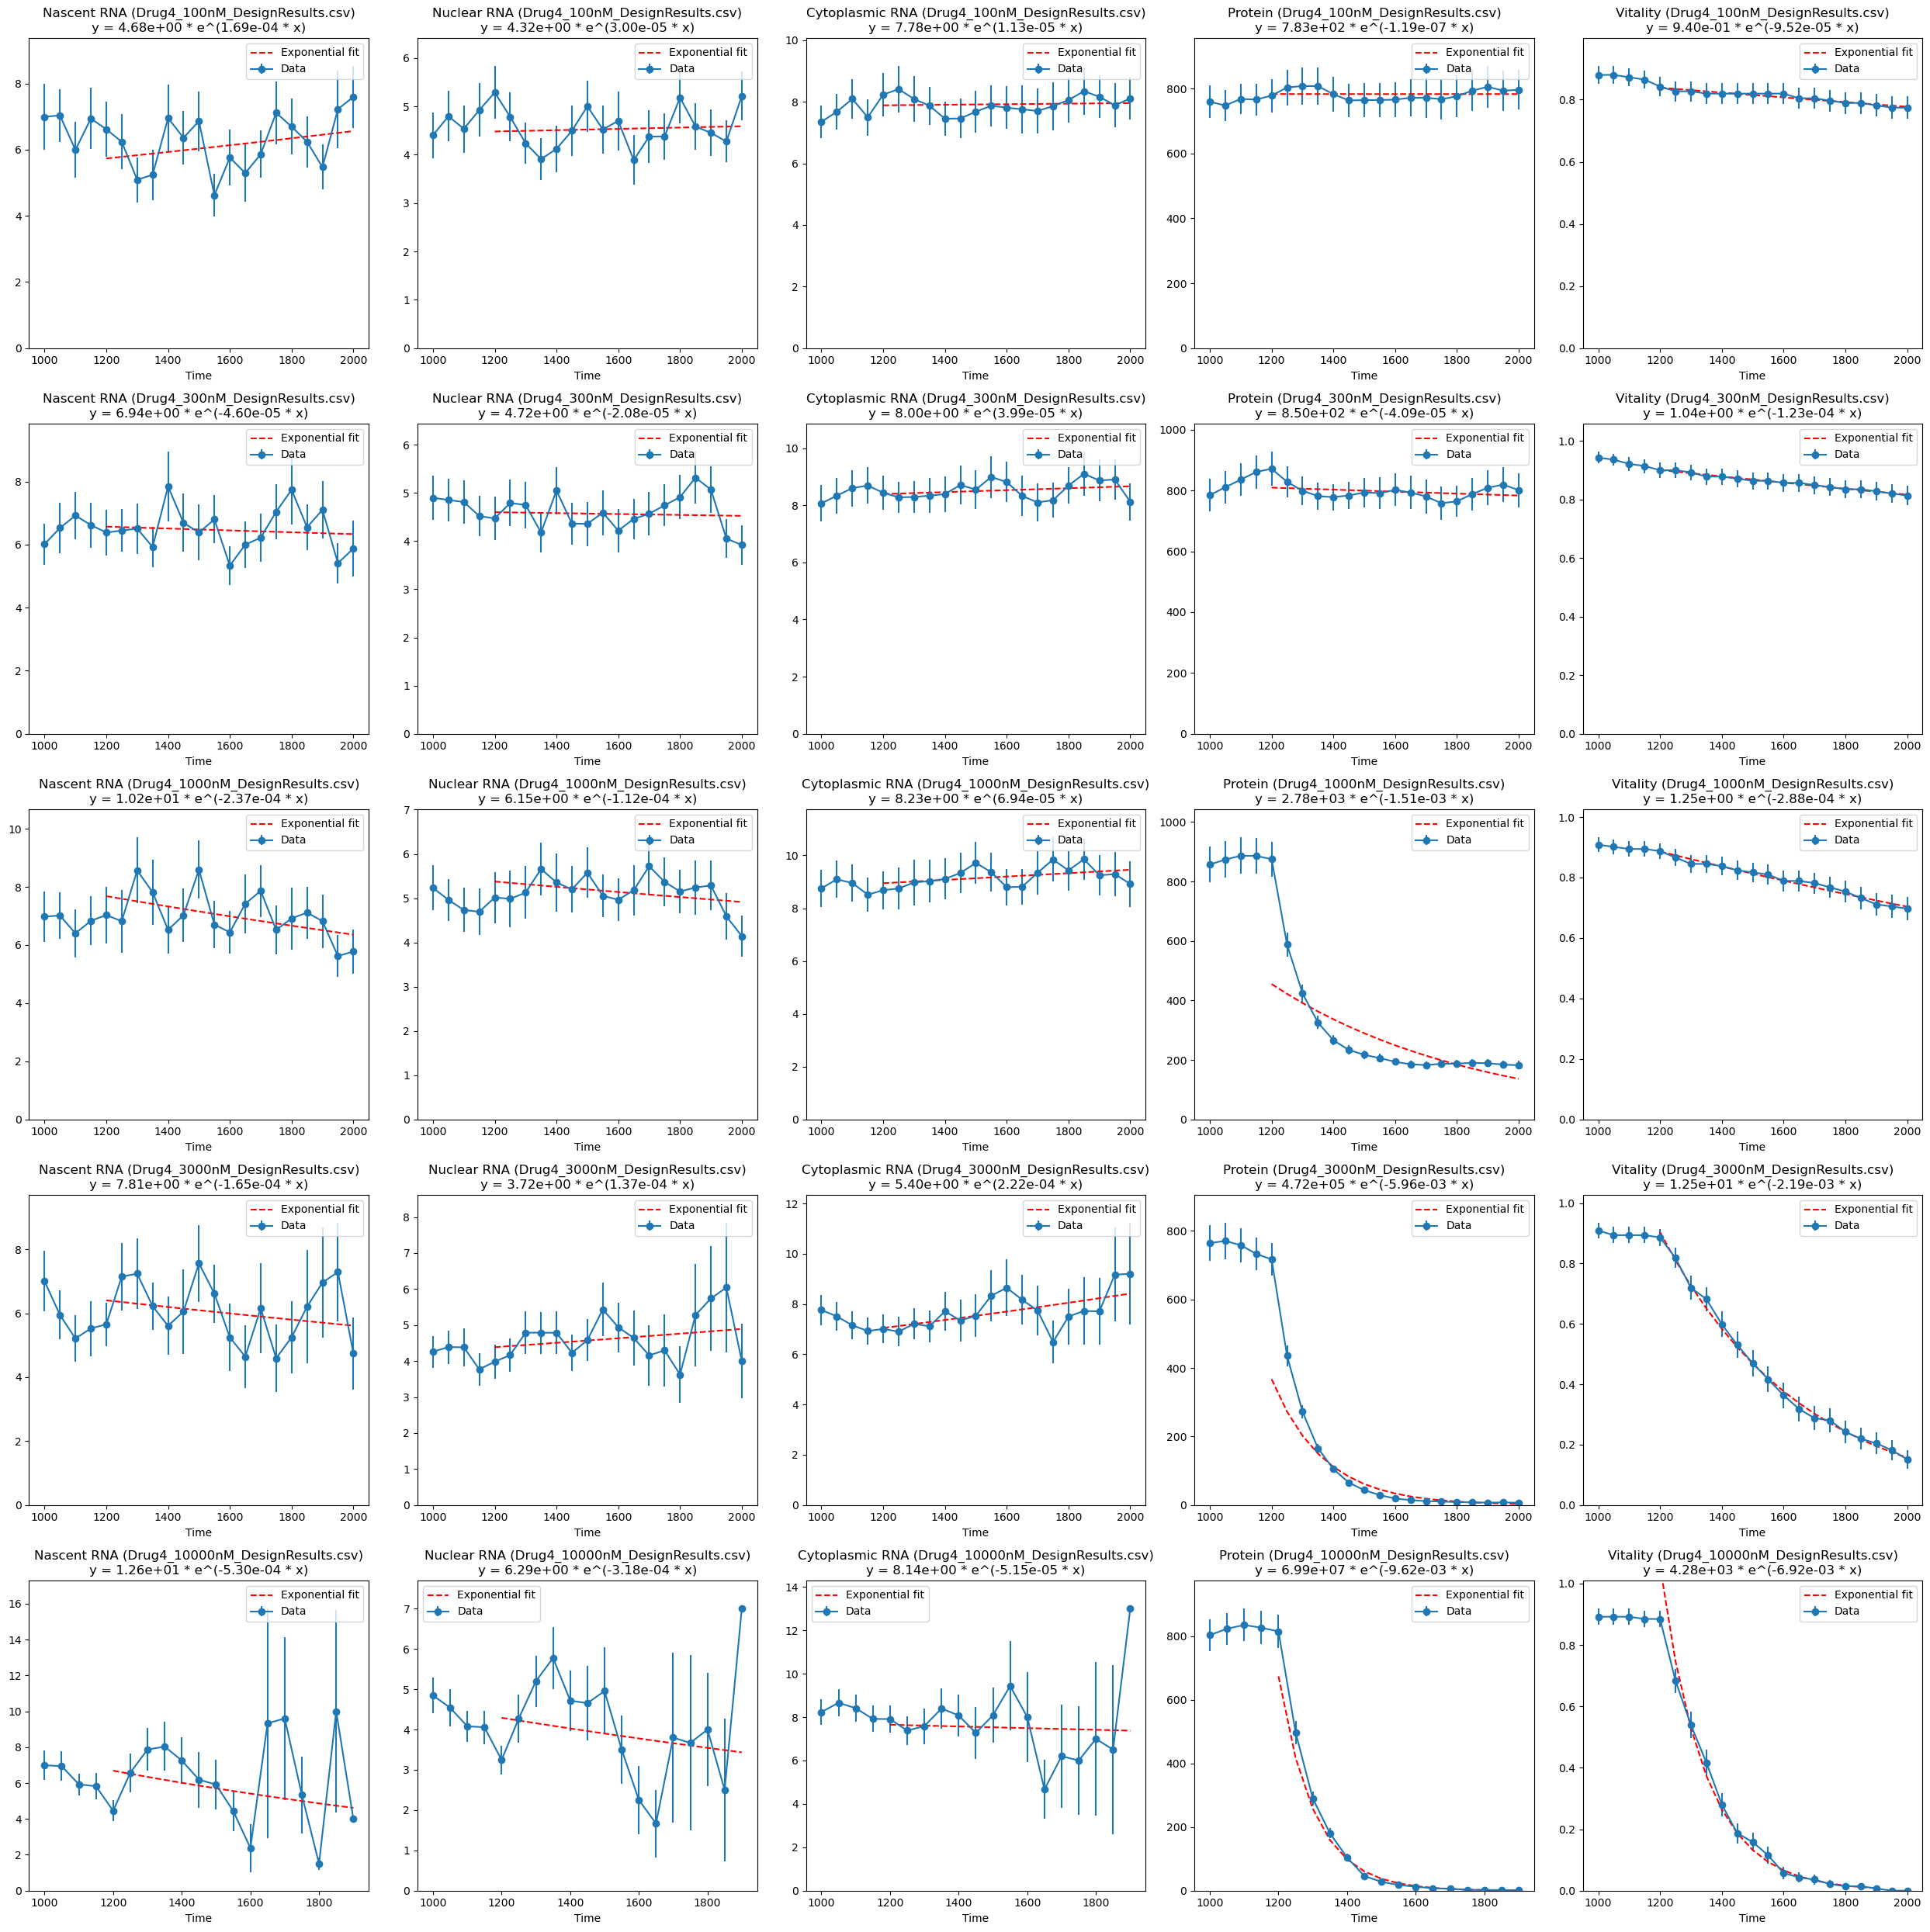

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

# Define the file paths
files = [
    'TrueData/Drug4_100nM_DesignResults.csv',
    'TrueData/Drug4_300nM_DesignResults.csv',
    'TrueData/Drug4_1000nM_DesignResults.csv',
    'TrueData/Drug4_3000nM_DesignResults.csv',
    'TrueData/Drug4_10000nM_DesignResults.csv'
]

# Feature names for plotting
featureNames = ['Nascent RNA', 'Nuclear RNA', 'Cytoplasmic RNA', 'Protein', 'Vitality']

# Initialize subplots
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

for file_idx, file in enumerate(files):
    dataRaw = pd.read_csv(file)

    k = 0

    Reps = np.unique(dataRaw['Rep_Num'])
    FOVs = np.unique(dataRaw['FOV_Num'])
    Times = np.unique(dataRaw['Time'])
    Cells = np.unique(dataRaw['Cell_id'])

    print(f'Processing file: {file}')
    print('Total Reps: ', len(Reps))
    print('Total FOVs: ', len(FOVs))
    print('Total cells: ', len(Cells))
    print('Time points: ', len(Times))

    dataTensor = np.zeros((len(Cells), len(Times), 5))

    for iCell in range(len(Cells)):
        for iTime in range(len(Times)):
            if dataRaw['is_cell_vital'][k] == 1:
                dataTensor[iCell, iTime, 0] = dataRaw['num_rna_nascent'][k]
                dataTensor[iCell, iTime, 1] = dataRaw['num_rna_nuc'][k]
                dataTensor[iCell, iTime, 2] = dataRaw['num_rna_cyto'][k]
                dataTensor[iCell, iTime, 3] = dataRaw['Cyto_Intensity_1'][k]
                dataTensor[iCell, iTime, 4] = 1
            else:
                dataTensor[iCell, iTime, 0] = np.nan
                dataTensor[iCell, iTime, 1] = np.nan
                dataTensor[iCell, iTime, 2] = np.nan
                dataTensor[iCell, iTime, 3] = np.nan
                dataTensor[iCell, iTime, 4] = 0
            k += 1
    # Calculate mean and SEM of each data type at each time point. Ignore NaN values.
    dataMean = np.nanmean(dataTensor, axis=0)
    dataStd = np.nanstd(dataTensor, axis=0) / np.sqrt(np.sum(~np.isnan(dataTensor), axis=0))

    for i in range(5):
        ax = axes[file_idx, i]
        ax.errorbar(Times, dataMean[:, i], yerr=dataStd[:, i], fmt='-o', label='Data')

        # Filter time points between 1200 and 2000
        filter_mask = (Times > 1150) & (Times <= 2000)
        filtered_times = Times[filter_mask]
        filtered_dataMean = dataMean[:, i][filter_mask]

        # Filter out zero or negative values for log transformation
        positive_mask = filtered_dataMean > 0
        filtered_times = filtered_times[positive_mask]
        filtered_dataMean = filtered_dataMean[positive_mask]

        # Calculate and plot the exponential line of best fit
        log_filtered_dataMean = np.log(filtered_dataMean)
        slope, intercept, _, _, _ = linregress(filtered_times, log_filtered_dataMean)
        best_fit_line = np.exp(intercept) * np.exp(slope * filtered_times)  # Use filtered_times here
        ax.plot(filtered_times, best_fit_line, color='red', linestyle='--', label='Exponential fit')  # Plot against filtered_times 

        # Calculate the exponential function parameters
        a = np.exp(intercept)
        b = slope
        function_text = f'y = {a:.2e} * e^({b:.2e} * x)'

        ax.set_title(f"{featureNames[i]} ({file.split('/')[-1]})\n{function_text}")
        ax.set_xlabel('Time')
        ax.set_ylim([0, 1.1 * np.nanmax(dataMean[:, i] + dataStd[:, i])])
        ax.legend()

plt.tight_layout()
plt.show()
